# Importing Packages
First, we start by importing some packages like `numpy`, `matplotlib` and also `torch`.

In [ ]:
import torch
import numpy as np
from torch import nn 
from torch.nn import functional as F
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
from random import randrange

# Chossing a device 
If there is a cuda available, we are going to train and use our model on gpu


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Encoder Implementation
Here, we define and implement the encoder part of the model, $Q(z|X, c)$. 

Throughout two hidden layers (linear nets using relu function), the encoder will reduce the dimenstion size of the initial feature space to a samller size.
Later, we will expect two outputs from this network, namely `mu` and `log_var`. Which are the $\mu$ and $\log(\sigma^2)$ of the latent points, conditioned by the class of initial point.




In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc_mu = nn.Linear(hidden_sizes[1], output_size)
        self.fc_var = nn.Linear(hidden_sizes[1], output_size)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var

# Decoder Implementation
Here, we define and implement the decoder part of the model, $P(X|z, c)$. 

Throughout two hidden layers (linear nets using relu and sigmoid function), the deocder will increase the dimenstion size of the latent feature space to a greater size, equal to that of the main feature space. The output is also conditioned by the class, so we can have a control over the reconstructed digit. 




In [ ]:
class Decoder(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
    def forward(self, z):
        z = self.relu(self.fc1(z))
        z = self.relu(self.fc2(z))
        x_hat = self.sigmoid(self.fc3(z))
        return x_hat

# cVAE Implementation
By connections two previous networks, decoder and encoder, we implement our vanilla VAE.

The encoder will get the images and their labels (as one-hot vectors) as inputs, concatenate them and then output two vectors, `mu` and `log_var` of the latent point. By sampling using these two vectors in function `reparam_sample`, we feed the decoder network, so it can take the sampled point back to the original feature space.

In [ ]:
class ConditionalVAE(nn.Module):
    def __init__(self, feature_size, hidden_sizes):
        super().__init__()
        self.encoder = Encoder(feature_size, hidden_sizes, 2)
        self.decoder = Decoder(12, hidden_sizes[::-1], 784)

    def reparam_sample(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, labels):
        mu, log_var = self.encoder(x)
        z = self.reparam_sample(mu, log_var)
        one_hot_labels = torch.eye(10, device=device)[labels]
        z_input = torch.cat((z, one_hot_labels), 1)
        x_hat = self.decoder(z_input)
        return x_hat, x, mu, log_var, z

# Train and Analyze VAE
In this class, we train the model using two loss forms. One is the reconstruction loss which measures the variance between the input vector and output vector created by the decoder. The other one measures how close the distribution of the latent points is to Nomal distribution, namely $N(0, I)$. For this error we use kullback leibler divergence, which measures the divergence between two distributions. 

Later in this class, in function `show_info` and `show_samples`, we visualize three plots:


1.   Train and validation loss throughout epochs
2.   The distribution of the latent space, as they are in a 2D feature space.  
3.   100 sample digits, reconstructed  by the the trained decoder using 100 points sampled from the 2D feature space. 



For epoch: 1, train loss is 10015.80793 and validation loss is 9593.68671
For epoch: 2, train loss is 8739.64910 and validation loss is 8412.85953
For epoch: 3, train loss is 8577.58574 and validation loss is 8239.20224
For epoch: 4, train loss is 8493.58159 and validation loss is 8126.76497
For epoch: 5, train loss is 8435.68871 and validation loss is 8045.42408
For epoch: 6, train loss is 8393.92150 and validation loss is 7966.80755
For epoch: 7, train loss is 8354.44682 and validation loss is 7894.62309
For epoch: 8, train loss is 8321.34715 and validation loss is 7846.90528
For epoch: 9, train loss is 8294.51491 and validation loss is 7832.10242
For epoch: 10, train loss is 8269.15890 and validation loss is 7823.24557
For epoch: 11, train loss is 8248.05464 and validation loss is 7791.83182
For epoch: 12, train loss is 8227.09147 and validation loss is 7765.89738
For epoch: 13, train loss is 8208.84750 and validation loss is 7747.20677
For epoch: 14, train loss is 8191.43718 and va

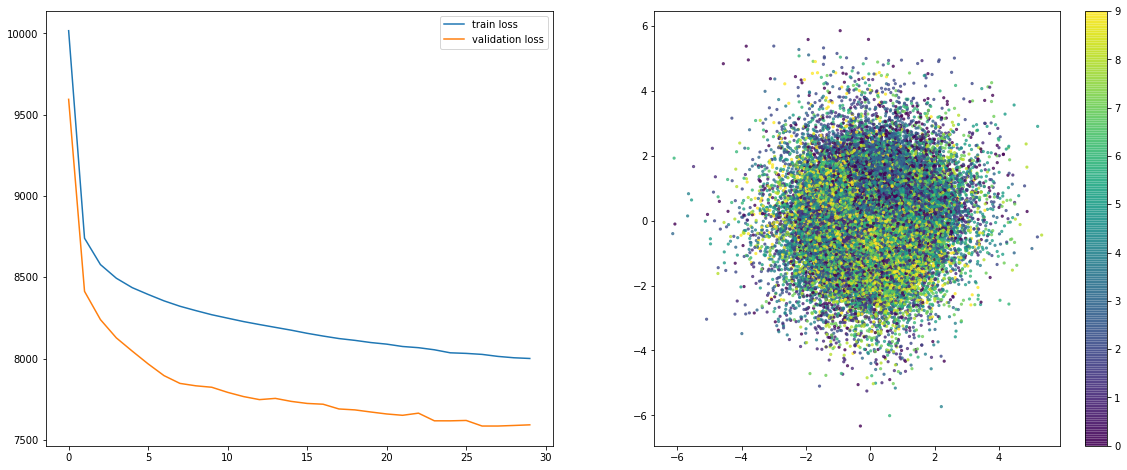

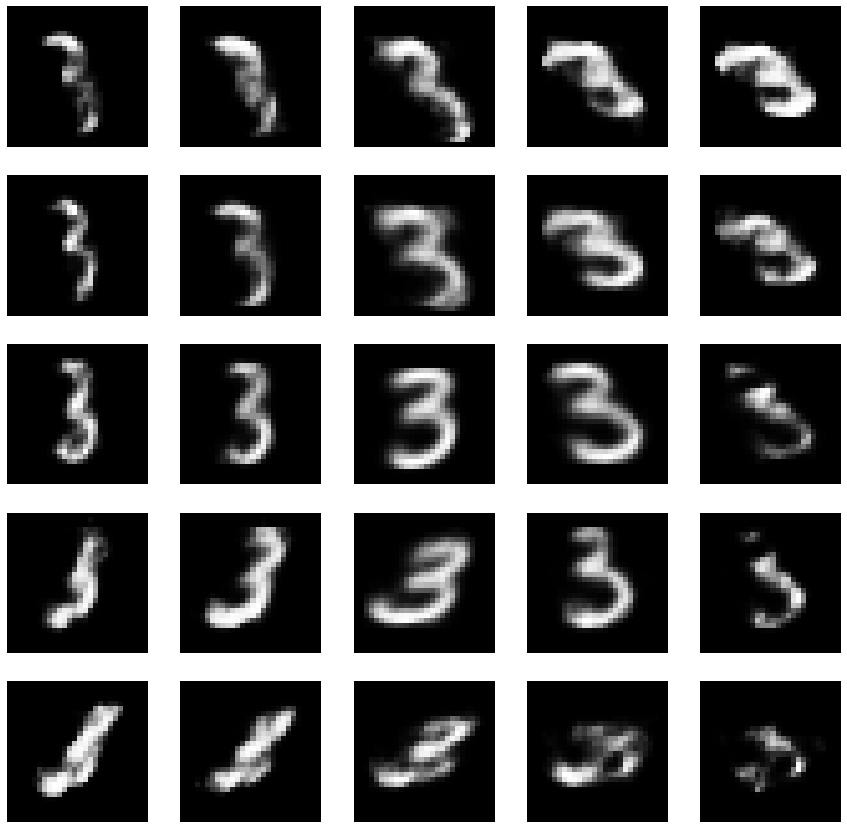

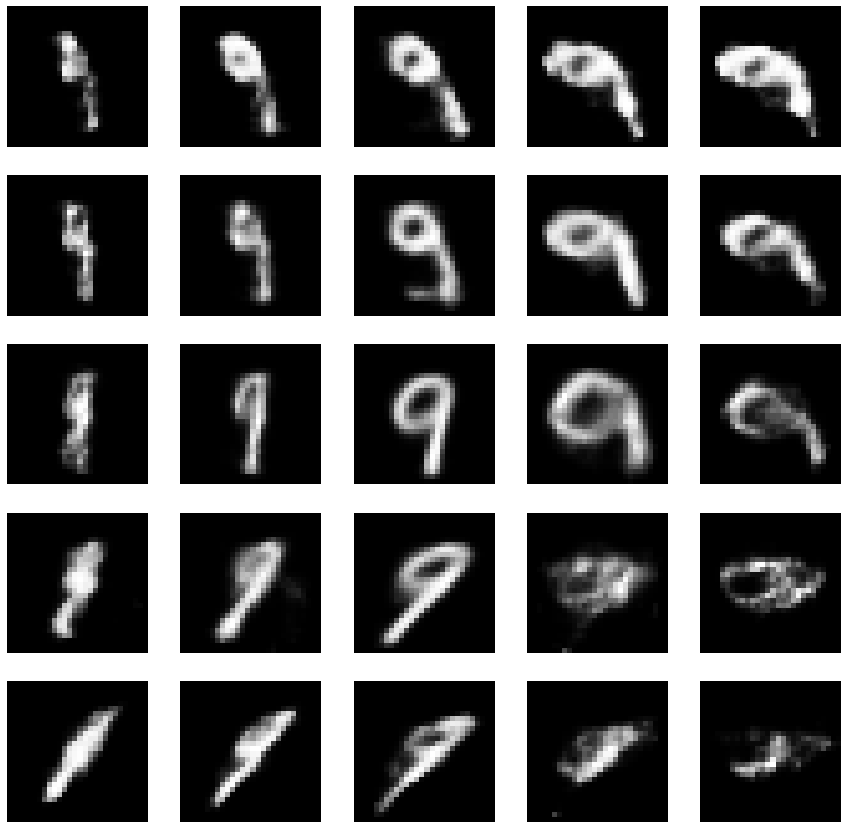

In [ ]:
class Model():
    def __init__(self, hidden_sizes):
        data = self.fetch_data()
        self.trainloader, self.validationloader = data
        self.cvae = ConditionalVAE(794, hidden_sizes=hidden_sizes).to(device)

    def train(self, epochs=30):
        optimizer = torch.optim.Adam(self.cvae.parameters())
        self.train_losses = []
        self.valid_losses = []
        for epoch in range(epochs):
            train_running_loss = 0
            valid_running_loss = 0
            for train_images, train_labels in self.trainloader:
                train_images = train_images.to(device)
                train_labels = train_labels.to(device)

                train_images.resize_(len(train_images), 784)
                one_hot_labels = torch.eye(10, device=device)[train_labels] 
                input_data = torch.cat((train_images, one_hot_labels), 1)

                x_hat, x, mu, log_var, z = self.cvae(input_data, train_labels)
                reconstruction_loss = F.binary_cross_entropy(x_hat, train_images, reduction='sum')
                kldiv_loss = 0.5 * torch.sum(torch.exp(log_var) + mu ** 2 - 1 - log_var)
                loss = kldiv_loss + reconstruction_loss
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_running_loss += loss.item()

                valid_images, valid_labels = iter(self.validationloader).next()
                valid_images = valid_images.to(device).resize_(len(valid_images), 784)
                one_hot_labels = torch.eye(10, device=device)[valid_labels] 
                input_data = torch.cat((valid_images, one_hot_labels), 1)
                x_hat, x, mu, log_var, z = self.cvae(input_data, valid_labels)
                reconstruction_valid_loss = F.binary_cross_entropy(x_hat, valid_images, reduction='sum')
                kldiv_valid_loss = 0.5 * torch.sum(torch.exp(log_var) + mu ** 2 - 1 - log_var)
                valid_loss = kldiv_valid_loss + reconstruction_valid_loss
                valid_running_loss += valid_loss.item()
            
            print('For epoch: {}, train loss is {:.5f} and validation loss is {:.5f}'.format(
                epoch+1, 
                train_running_loss / len(self.trainloader), 
                valid_running_loss / len(self.trainloader)))
            self.train_losses.append(train_running_loss / len(self.trainloader))    
            self.valid_losses.append(valid_running_loss / len(self.trainloader))
        self.show_info()

    def show_info(self):
        points = np.zeros((60000, 2))
        colors = np.zeros((60000, 1))

        i = 0
        for images, labels in self.trainloader:
            images.resize_(len(images), 784)
            images = images.to(device)
            one_hot_labels = torch.eye(10, device=device)[labels] 
            input_data = torch.cat((images, one_hot_labels), 1)
            latent = self.cvae(input_data, labels)[-1]
            for z, label in zip(latent, labels):
                points[i] = z.detach().to("cpu")
                colors[i] = label.detach().to("cpu")
                i += 1

        fig, axs = plt.subplots(1, 2, figsize=(20, 8))


        
        axs[0].plot(range(len(self.train_losses)), self.train_losses, label="train loss")
        axs[0].plot(range(len(self.valid_losses)), self.valid_losses, label="validation loss")
        axs[0].legend()
        
        img = axs[1].scatter(points[:, 0], points[:, 1], c=colors, alpha=0.7, s=5)
        fig.colorbar(img)

        print()     
        self.show_samples(points)
        
    def show_samples(self, points):
        label1, label2 = np.random.randint(0, 10, 2)
        print("Trying to produce digits {} and {}".format(label1, label2))
        x_min, y_min = np.min(points, axis=0)
        x_max, y_max = np.max(points, axis=0)
        xs = np.linspace(x_min, x_max, 5)
        ys = np.linspace(y_min, y_max, 5)
        
        recon_points1 = []
        recon_points2 = []
        for x in xs:
            for y in ys:
                z = torch.FloatTensor([x, y]).to(device)
                one_hot_labels = torch.eye(10, device=device)[label1]
                z_input = torch.cat((z.unsqueeze(0), one_hot_labels.unsqueeze(0)), 1)
                recon_points1.append(self.cvae.decoder(z_input).reshape(28, 28)) 
                
                one_hot_labels = torch.eye(10, device=device)[label2]
                z_input = torch.cat((z.unsqueeze(0), one_hot_labels.unsqueeze(0)), 1)
                recon_points2.append(self.cvae.decoder(z_input).reshape(28, 28)) 
        
        fig, axs = plt.subplots(5, 5, figsize=(15, 15))
        for i in range(5):
            for j in range(5):
                axs[i, j].imshow(recon_points1[5*i+j].cpu().detach(), cmap="gray")
                axs[i, j].set_axis_off()  

        fig, axs = plt.subplots(5, 5, figsize=(15, 15))
        for i in range(5):
            for j in range(5):
                axs[i, j].imshow(recon_points2[5*i+j].cpu().detach(), cmap="gray")
                axs[i, j].set_axis_off()  

    def fetch_data(self):
        transform = transforms.Compose([transforms.ToTensor()])
        trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
        validationset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
        validationloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=False)
        return trainloader, validationloader

model = Model(hidden_sizes=[500, 300])
model.train()                
